# Video Game Sales Prediction - Machine Learning Lab

## Introduction and Setup
Welcome to this machine learning lab where we'll build a model to predict
whether a video game will be a "hit" based on its characteristics and sales data.
This notebook will guide you through the entire process, from data loading to
model evaluation and optimization.

Learning objectives:
1. Learn to preprocess and explore a real-world dataset
2. Build and evaluate a decision tree classifier
3. Optimize a model through hyperparameter tuning
4. Interpret model results and feature importance

In [ ]:
#install libraries if necessary

# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Configure visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

In [ ]:
# Display settings for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Download the Dataset

In [ ]:
# You can run this cell to download the dataset directly, or upload it manually!
import requests

url = 'https://www.kaggle.com/datasets/gregorut/videogamesales/download'
response = requests.get(url)

with open('videogamesales.zip', 'wb') as f:
	f.write(response.content)

print("Dataset downloaded successfully.")


Dataset downloaded successfully.


## Load the Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('vgsales.csv')

# Let's take a look at the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   Rank                      Name Platform    Year         Genre Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo     41.49     29.02      3.77         8.46         82.74
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo     29.08      3.58      6.81         0.77         40.24
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo     15.85     12.88      3.79         3.31         35.82
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo     15.75     11.01      3.28         2.96         33.00
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo     11.27      8.89     10.22         1.00         31.37


## Dataset Information

In [ ]:
# Get basic information about the dataset
print("\nDataset basic information:")
print(df.info())

# Get descriptive statistics
print("\nDescriptive statistics:")
print(df.describe())


Dataset basic information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None

Descriptive statistics:
               Rank          Year      NA_Sales      EU_Sales      JP_Sales   Other_Sales  Global_Sales
count  16598.000000  16327.000000  16598.000000  16598.000000  16598.000000  16598.000000  16598.000000
mean

In [ ]:
# Cell 5:Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


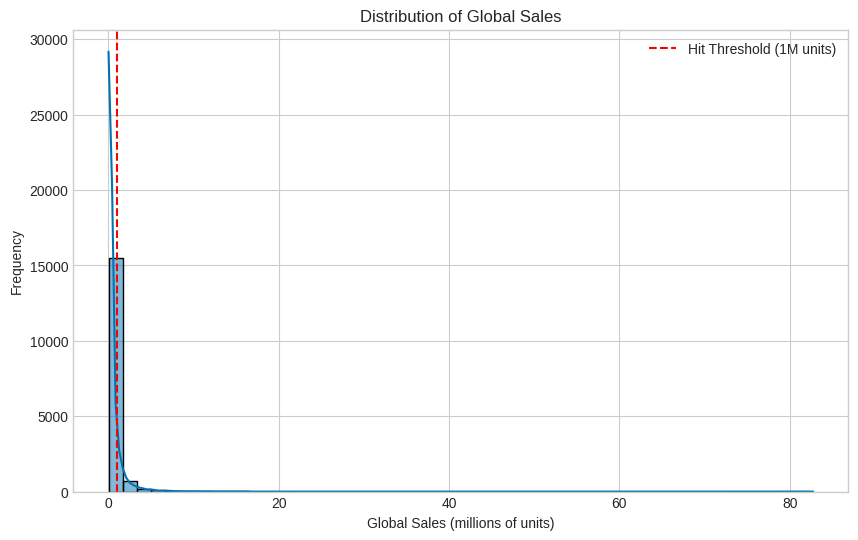

In [ ]:
# Cell 6: Data Visualization - Global Sales Distribution
# ====================================================
# Visualize the distribution of global sales
plt.figure(figsize=(10, 6))
sns.histplot(df['Global_Sales'], bins=50, kde=True)
plt.title('Distribution of Global Sales')
plt.xlabel('Global Sales (millions of units)')
plt.ylabel('Frequency')
plt.axvline(x=1, color='red', linestyle='--', label='Hit Threshold (1M units)')
plt.legend()
plt.show()

In [ ]:
# Cell 7: Create Target Variable
# ============================
# TASK: Create a binary target variable for "hit" games
# A game is considered a hit if it sold more than 1 million units (Global_Sales > 1)
df['Hit'] = (df['Global_Sales'] > 1).astype(int)
print("Target variable 'Hit' created successfully.")

Target variable 'Hit' created successfully.


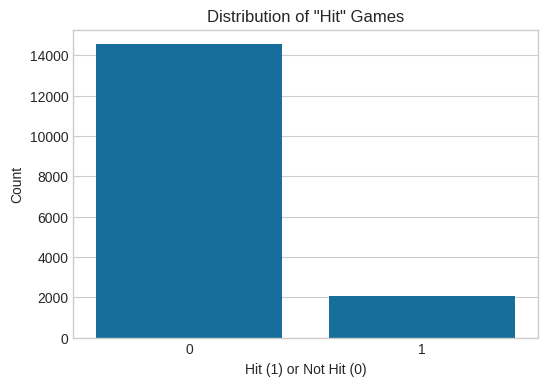

In [ ]:
# Cell 8: Analyze Target Distribution
# =================================
# Let's see the proportion of hits in our dataset
plt.figure(figsize=(6, 4))
sns.countplot(x='Hit', data=df)
plt.title('Distribution of "Hit" Games')
plt.xlabel('Hit (1) or Not Hit (0)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Cell 9: Drop Non-Informative Columns
# ==================================
# TASK: Drop non-informative columns
# Think about which columns won't help with prediction
df_clean = df.drop(['Rank', 'Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)
print("\nDropped non-informative columns.")
print(df_clean.head())


Dropped non-informative columns.
  Platform    Year         Genre Publisher  Global_Sales  Hit
0      Wii  2006.0        Sports  Nintendo         82.74    1
1      NES  1985.0      Platform  Nintendo         40.24    1
2      Wii  2008.0        Racing  Nintendo         35.82    1
3      Wii  2009.0        Sports  Nintendo         33.00    1
4       GB  1996.0  Role-Playing  Nintendo         31.37    1


In [ ]:
# Cell 10: Missing Value Analysis
# =============================
# Examine the 'Year' column which might have missing values
print("\nMissing values in 'Year' column:")
print(df_clean['Year'].isnull().sum())


Missing values in 'Year' column:
0


In [ ]:
# Cell 11: Handle Missing Values
# ============================
# TASK: Handle missing values
# Option 1: Drop rows with missing values
df_clean.dropna(subset=['Year'], inplace=True)

# Option 2: Fill missing values with median or mean
# df_clean['Year'] = df_clean['Year'].fillna(df_clean['Year'].median())

print("\nMissing values after handling:")
print(df_clean.isnull().sum())


Missing values after handling:
Platform         0
Year             0
Genre            0
Publisher       36
Global_Sales     0
Hit              0
dtype: int64


In [ ]:
# Cell 12: Categorical Variable Analysis
# ===================================
# Let's identify categorical columns
categorical_columns = df_clean.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns:", categorical_columns)


Categorical columns: ['Platform', 'Genre', 'Publisher']


In [ ]:
# Cell 13: Encode Categorical Variables
# ==================================
# TASK: Encode categorical variables using LabelEncoder
# Label Encoder transforms categorical variables into numerical ones
label_encoder = LabelEncoder()

In [ ]:
# Cell 14: Feature Engineering (Optional)
# =====================================
# BONUS TASK: Feature Engineering
# Creating new features might improve model performance
# Example: Total regional sales besides global



In [ ]:
# Cell 15: Explore Processed Dataset
# ================================
# Let's look at the processed dataset
print("\nProcessed dataset:")
print(df_clean.head())



Processed dataset:
   Platform    Year  Genre  Publisher  Global_Sales  Hit
0        26  2006.0     10        359         82.74    1
1        11  1985.0      4        359         40.24    1
2        26  2008.0      6        359         35.82    1
3        26  2009.0     10        359         33.00    1
4         5  1996.0      7        359         31.37    1


In [ ]:
# Cell 16: Split Features and Target
# ================================
# TASK: Split the data into features (X) and target (y)
X = df_clean.drop(['Hit', 'Global_Sales'], axis=1)
y = df_clean['Hit']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

Features (X) shape: (16327, 4)
Target (y) shape: (16327,)


In [ ]:
# Cell 17: Train-Test Split
# =======================
# TASK: Split the data into training and testing sets (80/20 split)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Print the shapes to confirm the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (13061, 4)
X_test shape: (3266, 4)
y_train shape: (13061,)
y_test shape: (3266,)


In [ ]:
# Cell 18: Train Initial Model
# ==========================
# TASK: Train a Decision Tree classifier with default parameters
# YOUR CODE HERE
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

print("Decision Tree model trained successfully.")

Decision Tree model trained successfully.


In [ ]:
# Cell 19: Make Predictions
# =======================
# TASK: Make predictions on the test set
# YOUR CODE HERE
y_pred = model.predict(X_test)

# Probability of being a hit
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Predictions made successfully.")

Predictions made successfully.


In [ ]:
# Cell 20: Calculate Evaluation Metrics
# ==================================
# TASK: Calculate evaluation metrics
# YOUR CODE HERE
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Accuracy: 0.8616
Precision: 0.3824
Recall: 0.3079
F1-Score: 0.3411
ROC AUC Score: 0.6912


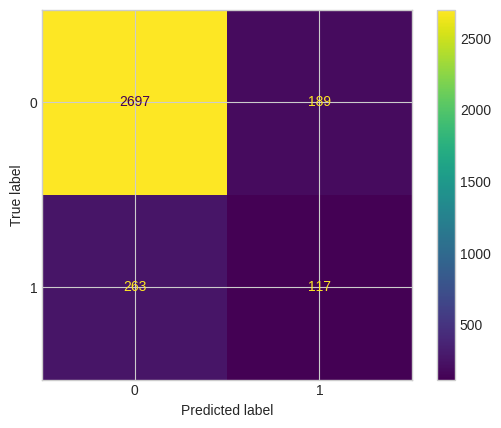

In [ ]:
# Cell 21: Confusion Matrix Visualization
# ====================================
# TASK: Visualize the confusion matrix
# YOUR CODE HERE
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()